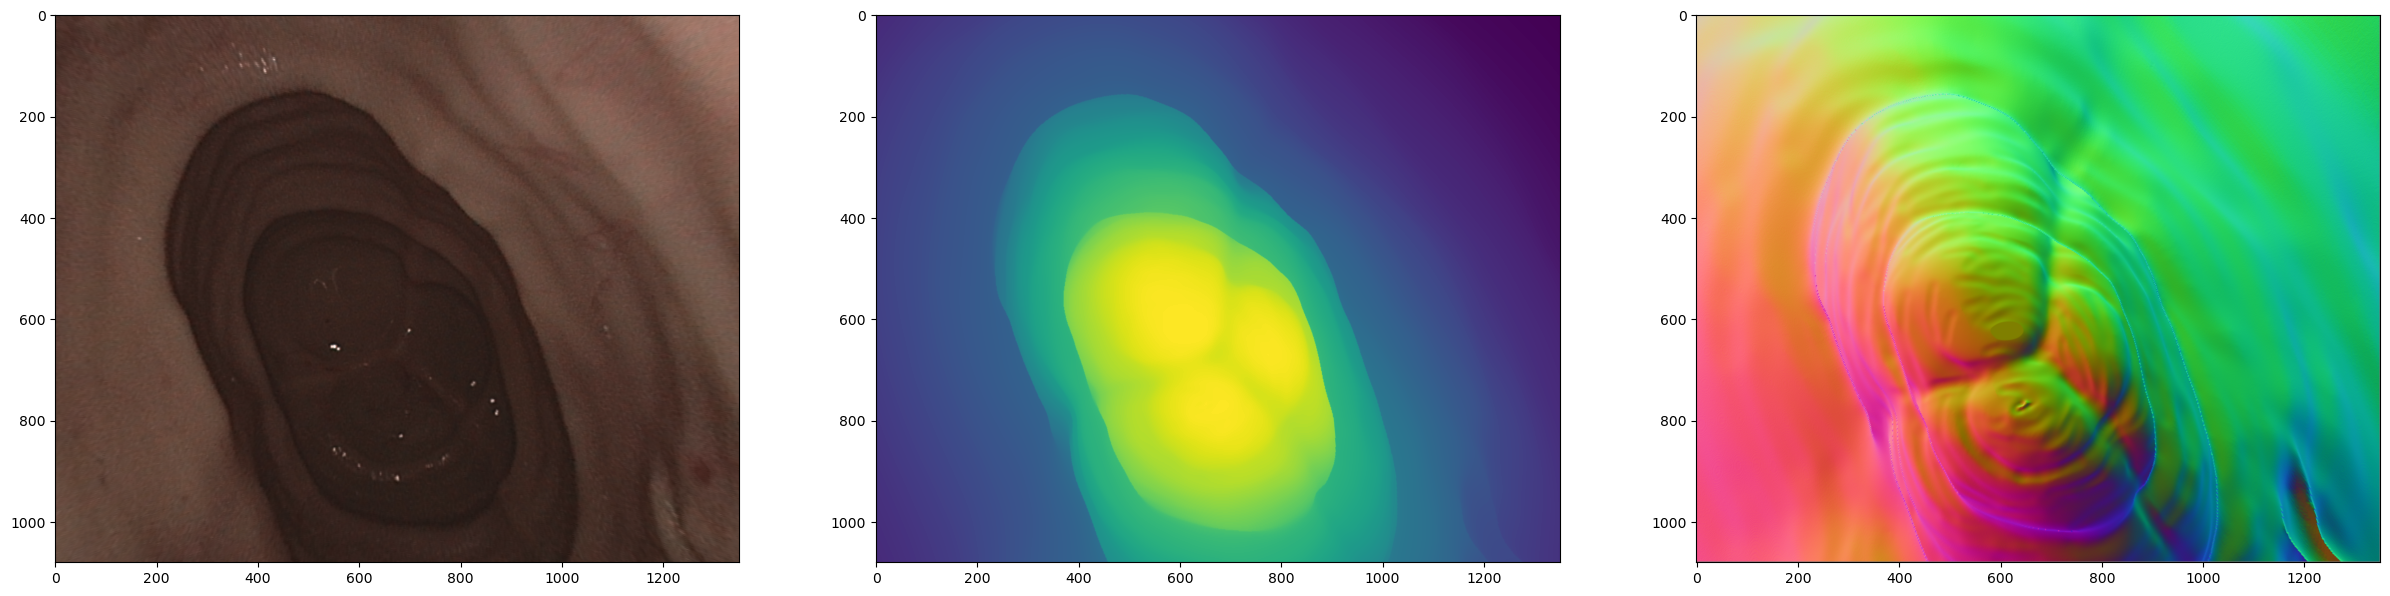

In [1]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pil
import torch.nn as nn

def read_c3vd_depth(f):
    return np.array(pil.open(f)).astype(np.float32)

import torch
import torch.nn.functional as F

import sys
sys.path.append("/home/data/workspace/heqi/monogastroendo/")
# warp feature points by depth and pose
# from layers import BackprojectDepth
height = 1080
width = 1350
# Layer to transform a depth image into a point cloud
class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return cam_points
backproj = BackprojectDepth(1, height, width)

def normalize(array):  # array is torch tensor
    return torch.nn.functional.normalize(array, p=2, dim=3, eps=1e-3)


flag_XY = True
X = torch.zeros([0])
Y = torch.zeros([0])

def depth2normal_perse(depth, intrinsics):
    global flag_XY, X, Y
    # depth: [B,1,H,W]
    # intrinsics: [fx, fy, cx, cy]
    fx, fy, cx, cy = intrinsics
    B, _, H, W = depth.shape
    inv_fx = 1.0 / fx
    inv_fy = 1.0 / fy
    depth = depth[:, 0, :, :]

    if flag_XY:
        Y, X = torch.meshgrid(torch.tensor(range(H)), torch.tensor(range(W)))
        X = X.unsqueeze(0).repeat(B, 1, 1).float()  # (B,H,W)
        Y = Y.unsqueeze(0).repeat(B, 1, 1).float()
        flag_XY = False

    x_cord_p = (X - cx) * inv_fx * depth
    y_cord_p = (Y - cy) * inv_fy * depth

    p = torch.stack([x_cord_p, y_cord_p, depth], dim=3)  # (B,H,W,3)

    # vector of p_3d in west, south, east, north direction
    p_ctr = p[:, 1:-1, 1:-1, :]
    vw = p_ctr - p[:, 1:-1, 2:, :]
    vs = p[:, 2:, 1:-1, :] - p_ctr
    ve = p_ctr - p[:, 1:-1, :-2, :]
    vn = p[:, :-2, 1:-1, :] - p_ctr
    normal_1 = torch.cross(vs, vw)  # (B,H-2,W-2,3)
    normal_2 = torch.cross(vn, ve)
    normal_1 = normalize(normal_1)
    normal_2 = normalize(normal_2)
    normal = normal_1 + normal_2
    normal = normalize(normal)
    paddings = (0, 0, 1, 1, 1, 1, 0, 0)
    normal = torch.nn.functional.pad(normal, paddings, 'constant')  # (B,H,W,3)
    return normal  # (B,H,W,3)


def normals_to_bgr(normal, rgb=False):
    # Map the normal vectors to the [0, 255] range and convert to uint8
    normal = (normal + 1) * 127.5
    # normal = normal.clip(0, 255).astype(np.uint8)
    normal = normal.clip(0, 255).astype(np.uint8)

    if rgb:
        return normal
    else:
        # Save the normal map to a file
        normal_bgr = cv2.cvtColor(normal, cv2.COLOR_RGB2BGR)
        
        return normal_bgr


# read depth image
rgb = pil.open('/home/data/workspace/heqi/monogastroendo/rect_c3vd_data/cecum_t1_a_under_review/c1v1/5_color.png')
depth_map = read_c3vd_depth('/home/data/workspace/heqi/monogastroendo/rect_c3vd_data/cecum_t1_a_under_review/c1v1/5_depth.tiff')

K = np.array([[0.56959306, 0, 0.5, 0],
            [0, 0.71185083, 0.5, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32)

K[0, :] *= width
K[1, :] *= height

depth_tensor = torch.tensor(depth_map*100./(2**16-1))[None, ...]
inv_K_tensor = torch.from_numpy(np.linalg.pinv(K))[None, ...]
# cam_points = backproj(depth_tensor, inv_K_tensor)
# calculate surface normal

# normal = depth2normv2(cam_points, height, width, nei=1)[0]
intrinsics = [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]
normal = depth2normal_perse(depth_tensor[None, ...], intrinsics)
normal = 0 - normal
normal_rgb = normals_to_bgr(normal[0].numpy(), rgb=True)
    
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(30, 10)

axes[0].imshow(rgb)
axes[1].imshow(depth_map)
axes[2].imshow(normal_rgb)

plt.show()

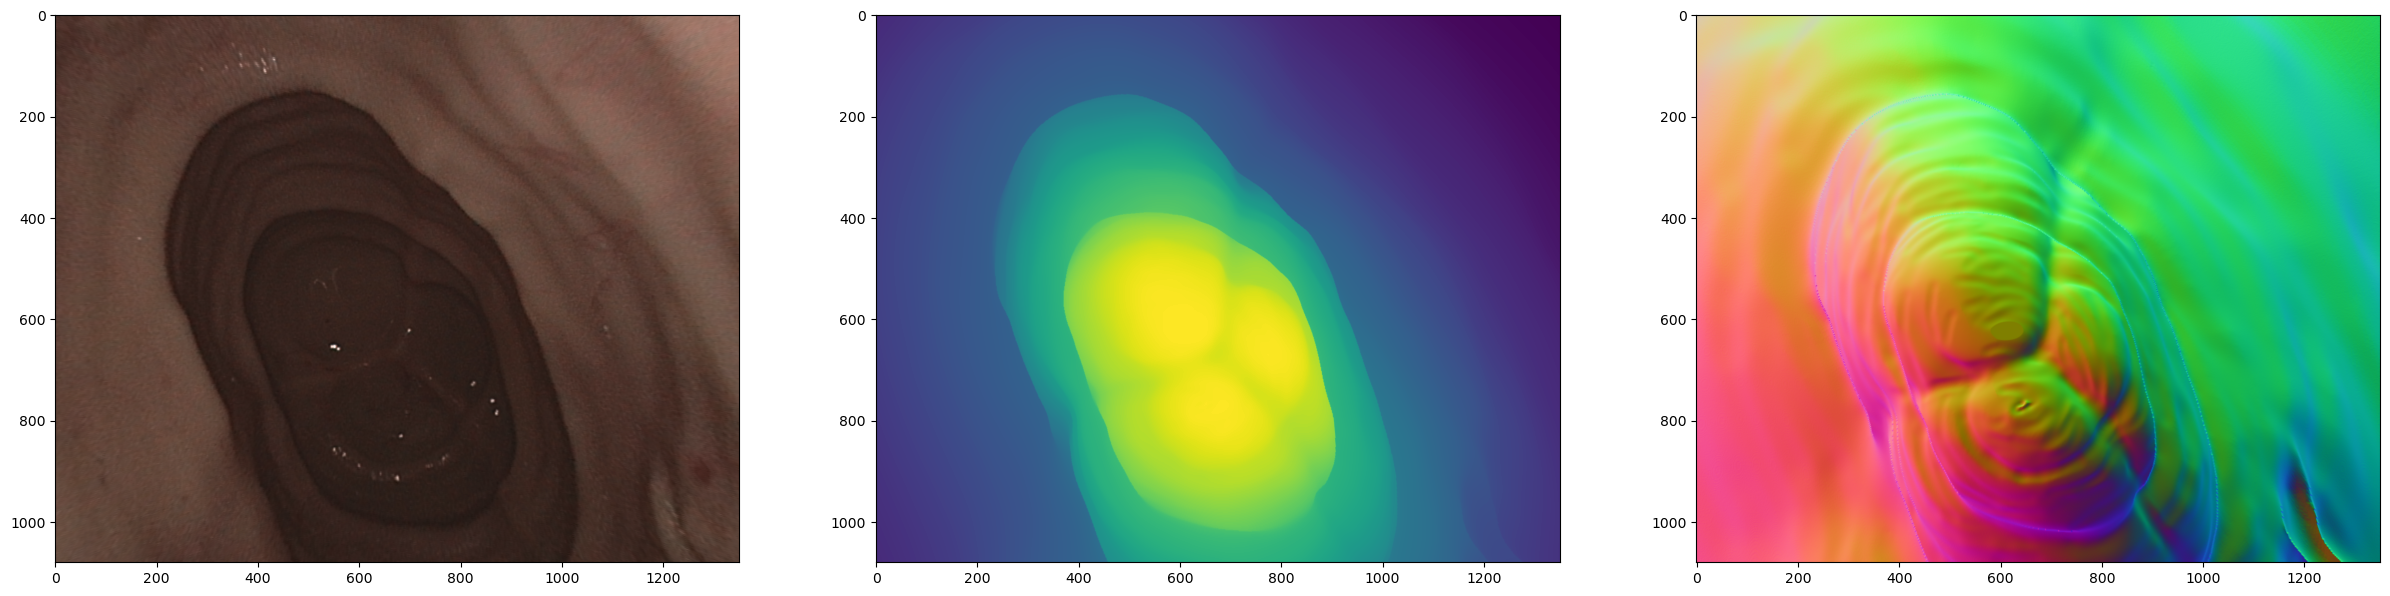

In [2]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pil

def read_c3vd_depth(f):
    return np.array(pil.open(f)).astype(np.float32)

import torch
import torch.nn.functional as F

import sys
sys.path.append("/home/data/workspace/heqi/monogastroendo/")
# warp feature points by depth and pose
# from layers import BackprojectDepth, Project3D
height = 1080
width = 1350
# Layer to transform a depth image into a point cloud
backproj = BackprojectDepth(1, height, width)

def normalize(array):  # array is torch tensor
    return torch.nn.functional.normalize(array, p=2, dim=3, eps=1e-3)

def depth2normv2(cam_points, height, width, nei=3):
    pts_3d_map = cam_points[:, :3, :].permute(0,2,1).view(-1, height, width, 3)
#     pts_3d_map = cam_points # (B, H, W, 3)
    
    ## shift the 3d pts map by nei along 8 directions
    pts_3d_map_ctr = pts_3d_map[:,nei:-nei, nei:-nei, :]
    pts_3d_map_x0 = pts_3d_map[:,nei:-nei, 0:-(2*nei), :]
    pts_3d_map_y0 = pts_3d_map[:,0:-(2*nei), nei:-nei, :]
    pts_3d_map_x1 = pts_3d_map[:,nei:-nei, 2*nei:, :]
    pts_3d_map_y1 = pts_3d_map[:,2*nei:, nei:-nei, :]
    pts_3d_map_x0y0 = pts_3d_map[:,0:-(2*nei), 0:-(2*nei), :]
    pts_3d_map_x0y1 = pts_3d_map[:,2*nei:, 0:-(2*nei), :]
    pts_3d_map_x1y0 = pts_3d_map[:,0:-(2*nei), 2*nei:, :]
    pts_3d_map_x1y1 = pts_3d_map[:,2*nei:, 2*nei:, :]

    ## generate difference between the central pixel and one of 8 neighboring pixels
    diff_x0 = pts_3d_map_ctr - pts_3d_map_x0
    diff_x1 = pts_3d_map_ctr - pts_3d_map_x1
    diff_y0 = pts_3d_map_y0 - pts_3d_map_ctr
    diff_y1 = pts_3d_map_y1 - pts_3d_map_ctr
    diff_x0y0 = pts_3d_map_x0y0 - pts_3d_map_ctr
    diff_x0y1 = pts_3d_map_ctr - pts_3d_map_x0y1
    diff_x1y0 = pts_3d_map_x1y0 - pts_3d_map_ctr
    diff_x1y1 = pts_3d_map_ctr - pts_3d_map_x1y1

    diff_x0 = diff_x0.reshape(-1, 3)
    diff_y0 = diff_y0.reshape(-1, 3)
    diff_x1 = diff_x1.reshape(-1, 3)
    diff_y1 = diff_y1.reshape(-1, 3)
    diff_x0y0 = diff_x0y0.reshape(-1, 3)
    diff_x0y1 = diff_x0y1.reshape(-1, 3)
    diff_x1y0 = diff_x1y0.reshape(-1, 3)
    diff_x1y1 = diff_x1y1.reshape(-1, 3)

    ## calculate normal by cross product of two vectors
    normals0 = F.normalize(torch.cross(diff_y1, diff_x1))
    normals1 = F.normalize(torch.cross(diff_y0, diff_x0))
    normals2 = F.normalize(torch.cross(diff_x0y0, diff_x0y1))
    normals3 = F.normalize(torch.cross(diff_x1y1, diff_x1y0))


    normal_vector = torch.sum(torch.stack([normals0, normals1, normals2, normals3], 0),0)
    normal_vector = F.normalize(normal_vector)

    normal_vector = normal_vector.view(pts_3d_map_ctr.shape).permute(0,3,1,2)
    normal_vector = F.pad(normal_vector, (nei,nei,nei,nei),"replicate")
    normal = normal_vector

    
    return normal # (3, H, W)

def normals_to_bgr(normal, rgb=False):
    # Map the normal vectors to the [0, 255] range and convert to uint8
    normal = (normal + 1) * 127.5
    normal = normal.clip(0, 255).astype(np.uint8)

    if rgb:
        return normal
    else:
        # Save the normal map to a file
        normal_bgr = cv2.cvtColor(normal, cv2.COLOR_RGB2BGR)
        
        return normal_bgr


def normals_to_mode(normal, mode=(0, 1, 2)):
    # Map the normal vectors to the [0, 255] range and convert to uint8
    normal = (normal + 1) * 127.5
    normal = normal.clip(0, 255).astype(np.uint8)

    normal_mode = np.stack([normal[:, :, mode[i]] for i in range(3)], axis=-1)
    return normal_mode


# read depth image
rgb = pil.open('/home/data/workspace/heqi/monogastroendo/rect_c3vd_data/cecum_t1_a_under_review/c1v1/5_color.png')
depth_map = read_c3vd_depth('/home/data/workspace/heqi/monogastroendo/rect_c3vd_data/cecum_t1_a_under_review/c1v1/5_depth.tiff')

K = np.array([[0.56959306, 0, 0.5, 0],
            [0, 0.71185083, 0.5, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32)

K[0, :] *= width
K[1, :] *= height

depth_tensor = torch.tensor(depth_map*100./(2**16-1))[None, ...]
inv_K_tensor = torch.from_numpy(np.linalg.pinv(K))[None, ...]
cam_points = backproj(depth_tensor, inv_K_tensor)

# cauculate surface normal

normal = depth2normv2(cam_points, height, width, nei=1)[0]
# intrinsics = [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]
# normal = depth2normal_perse(depth_tensor[None, ...], intrinsics)
normal = 0 - normal
normal_rgb = normals_to_bgr(normal.permute(1, 2, 0).numpy(), rgb=True)
normal_bgr = normals_to_bgr(normal.permute(1, 2, 0).numpy(), rgb=False)
normal_mode = normals_to_mode(normal.permute(1, 2, 0).numpy(), mode=(2, 0, 1))
    
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(30, 10)

axes[0].imshow(rgb)
axes[1].imshow(depth_map)
axes[2].imshow(normal_rgb)

plt.show()

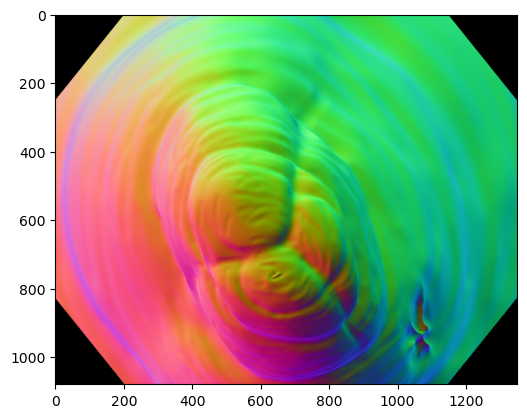

In [3]:
src_distorted_normal = cv2.imread("/home/data/workspace/heqi/monogastroendo/c3vd_data_v2/cecum_t1_a_under_review/0005_normals.tiff", -1)
src_distorted_normal_mask = np.bitwise_and(np.bitwise_and(src_distorted_normal[:, :, 0] == 0, src_distorted_normal[:, :, 1] == 0), src_distorted_normal[:, :, 2] == 0)
src_distorted_normal_norm = src_distorted_normal / (2**16 - 1)

distorted_normal_rgb = cv2.cvtColor((src_distorted_normal_norm*255).astype(np.uint8), cv2.COLOR_BGR2RGB)

plt.imshow(distorted_normal_rgb)

(array([ 81231.,  80123., 139142., 202237., 285861., 279170., 187321.,
         64580.,  26903.,   9383.]),
 array([-1.        , -0.81710231, -0.63420462, -0.45130694, -0.26840925,
        -0.08551156,  0.09738613,  0.28028382,  0.46318151,  0.64607919,
         0.82897688]),
 <BarContainer object of 10 artists>)

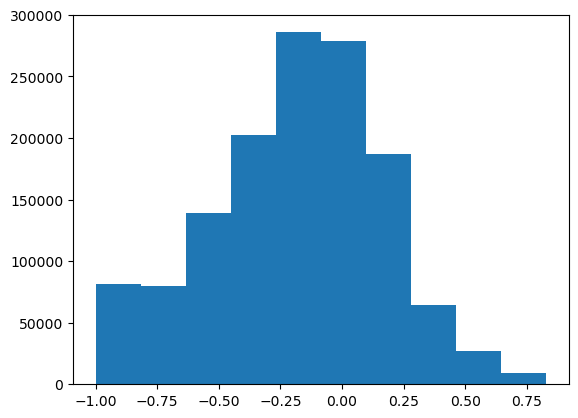

In [4]:
distorted_normal = src_distorted_normal_norm * 2 - 1
distorted_normal_sign = distorted_normal * (1-src_distorted_normal_mask)[..., None]
plt.hist(distorted_normal_sign[:, :, 0].flatten()[(1-src_distorted_normal_mask).flatten().astype(bool)])